# Trabalho Prático 1: Geometria Computacional
**Nome:** Lucas Xavier Veneroso

**Matricula:** 2016065138

**Nome:** Sarah Oliveira Elias

**Matricula:** 2018048478

# Introdução

Neste trabalho procuramos conseguir, dado um conjunto de dados, cada um com dois atributos (um representando sua posição em relação ao eixo x e outro representando-a em relação ao eixo y, fazendo assim com que o dado seja um ponto em um espaco 2-d), separáveis em duas classes:



*  Uma função que determina se essas duas classes são linearmente separáveis, isto é, se não há interseção entre as áreas que cada conjunto de dados ocupa
*   Se são linearmente separáveis, um modelo que consiga classificar um ponto novo, determinando a qual classe esse ponto pertence
*   E, por fim, calcular o quão bom esse modelo é, baseado nas métricas de precisão, revocação e f1-score 



# Preparações

## Bibliotecas Incluídas

Aqui temos as bibliotecas incluídas e imports feitos pelo grupo para a implementação deste projeto:

In [ ]:
from functools import cmp_to_key
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Classes

Construindo duas classes que serão utilizadas em várias seções dos algoritmos usados. Entraremos em mais detalhes sobre aspectos específicos destas classes que julgamos necessários de esclarecimento:

A classe Ponto é bem simples: cria um ponto com três atributos. Dois desses atributos são auto-explicativos: o x e y do ponto. O terceiro atributo, endpointFlag, que é inicialmente inicializado como nada, é utilizado e inicializado pela classe Segmento para saber qual dos pontos é o inicial (endpointFlag = 0) e qual é o final (endpointFlag = 1) em relação à suas coordenadas x.

Sobre a classe Segmento, temos como um dos elementos notáveis a presença de uma hullFlag, que tem uma função similar à Flag anteriormente discutida, neste caso um indicador de qual envoltória o segmento pertence. Outra parte notável dessa classe é os pontos pertencentes à ela serem criados dentro do inicalizador e não passados de fora. A razão para tal vem do modo como Python funciona. Em Python toda variável e objeto é passada "por referencia" o que significa que, se passássemos um objeto Ponto, já existente, para o segmento, ao colocar uma endpoint flag nesse Ponto, todos os outros segmentos que compartilham aquele Ponto também teriam a endpoint flag de um de seus pontos alterada, já que todos esses segmentos estão acessando exatamente o mesmo objeto e não uma cópia dele. Isso nos deixaria com segmentos com dois pontos "finais" ou dois pontos "iniciais", o que é problemático. Para resolver este problema nós passamos e utilizamos os valores de x e y de dois pontos e o inicializador constrói o Ponto dentro dele, a partir destes valores, fazendo com que essa instância do Ponto, diferentemente do exemplo anterior que era mais global, seja local e pertencente apenas àquele segmento especifico. O último aspecto notável é o primeiro if que confere se os dois pontos do segmento possuem o mesmo x, isto é, se o segmento é ortogonal ao eixo x. Sendo esse o caso temos que modificar um dos pontos para estar a direita (em relação a x) do outro, caso contrário, o algoritmo para descobrir se há interseção de segmentos pode ter um comportamento indesejado.

In [ ]:
class Ponto:
  def __init__(ponto,x,y,endpointFlag = None):
    ponto.x = x
    ponto.y = y
    #Flag definida por um segmento para determinar qual é o endpoint da direita e qual é o da esquerda
    ponto.endpointFlag = endpointFlag 


class Segmento:
  def __init__(seg,p0x,p0y,p1x,p1y,hullFlag = None): 
    #Condiçao necessaria para funcionamento da Varredura Linear
    if p0x == p1x:
      p1x += 0.01
    #Assignment da endpointFlag baseado na posiçao relativa a x das pontas do segmento
    if p0x<p1x:
      p0endpointFlag = 0
      p1endpointFlag = 1
    else:
      p0endpointFlag = 1
      p1endpointFlag = 0
    p0 = Ponto(p0x,p0y,p0endpointFlag)
    p1 = Ponto(p1x,p1y,p1endpointFlag)
    seg.endpointA = p0
    seg.endpointB = p1
    #Flag definida por uma envoltória para determinar à qual envoltória o segmento pertence
    seg.hullFlag = hullFlag

## Funçoes Basicas/"Primitivas"

Essas funções são simples e universais para vários problemas, sendo uma delas a primitiva para determinar posição de um ponto/segmento em relação a outro vista em sala de aula.

In [ ]:
# direçao relativa entre os segmentos p0p1 e p0p2
def direcao(p0, p1, p2):
  return ( (p1.x - p0.x) * (p2.y - p0.y) ) - ( (p2.x - p0.x) * (p1.y - p0.y) ) 

# quadrado da distancia entre dois pontos
def distancia(p1, p2):
  return ( (p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y) )

# Algoritmos Base Usados

## Envoltória Convexa

Para o problema de se criar uma envoltória convexa para cada classe dos dados foi escolhido o algoritmo de Varredura de Graham para ser implementado. Segue sua implementação:

### Varredura de Graham

O primeiro passo para a Varredura de Graham é achar um ponto âncora, aqui chamado de pancora. Note que a variável é declarada como global, escolha feita tendo em mente seu uso em funções mais a frente. Temos também a função que acha qual é o ponto âncora entre um conjunto de pontos, sendo ele o ponto que tem o menor y e em caso de empate o mais a esquerda.

In [ ]:
pancora = 0

def encontraAncora(points):
  ancora = points[0]
  for i in range(0, len(points)):
    if ( (points[i].y < ancora.y) or (points[i].y == ancora.y and points[i].x < ancora.x) ):
      ancora = points[i]
      index = i
  return ancora

A função compara aqui implementada é uma função auxiliar que será usada para ordenar os pontos de acordo com seu ângulo polar com o âncora, comparando dois pontos e retornando um indicador de qual dos dois é o com menor coordenada. Aqui vemos um dos motivos para a necessidade de pancora ser uma variável global: A função compara, por ser usada como uma função key (cmp_to_key) para comparação só pode receber dois parametros (os elementos a serem comparados). Como esses dois elementos estão sendo comparados com um terceiro (o ponto âncora) para determinar sua ordem, e este terceiro não pode ser passado para a função, podemos utilizar esse ponto pivô da comparaçao dentro da função sem problemas se ele for uma variavel global.   

In [ ]:
# Função para ordenar os pontos de acordo com a coordenada polar
def compara(p1, p2):
  d = direcao(pancora, p1, p2)

  if (d == 0):
    if (distancia(pancora, p1) <= distancia(pancora, p2)):
      return 1
    else:
      return -1
  else:
    if (d > 0):
      return 1
    else:
      return -1

A implementação do algoritmo de Graham é bem parecida com àquela vista em aula: Nós descobrimos o ponto âncora (e o colocamos numa variável global); ordenamos os pontos em relação à âncora (usando o sorted de python com a função compara provendo a chave); filtramos fora aqueles que tem o mesmo ângulo polar, escolhendo aquele que é mais próximo do âncora; e criamos a envoltória utilizando a primitiva para calcular em qual direção o próximo ponto está (modificando a envoltória sempre que houver um desvio para a direita no caminho). No final a função nos retorna uma lista de pontos vértices da envoltória.

In [ ]:
def graham(pontos):

  global pancora
  pancora = encontraAncora(pontos)
  
  # ordena de acordo com o angulo polar em relacao ao ancora
  pontosOrdenados = sorted(pontos, key=cmp_to_key(compara))

  # retira pontos com o mesmo angulo polar
  indices = []
  pontosOrdenados = np.insert(pontosOrdenados, 0, pancora, axis=0)
  for i in range(1, len(pontosOrdenados) - 1):
    d = direcao(pancora, pontosOrdenados[i], pontosOrdenados[i + 1])
    # mesmo angulo polar - remove o mais distante do ponto ancora
    if ( d == 0 ):
      if ( distancia(pancora, pontosOrdenados[i]) > distancia(pancora, pontosOrdenados[i+1]) ):
        indices.append(i+1)
      else:
        indices.append(i)
  pontos = np.delete(pontosOrdenados, indices)

  # inicia a expansao da envoltoria
  solucao = []
  solucao.append(pontos[0])
  solucao.append(pontos[1])
  solucao.append(pontos[2])

  for i in range(3, len(pontos)):
    while(len(solucao) > 1 and (solucao[-2]) and direcao(solucao[-2], solucao[-1], pontos[i]) >= 0):
      solucao.pop()
    solucao.append(pontos[i])
  
  return solucao

## Interseção Entre Segmentos em um Conjunto

Para resolver este problema foi implementado o algoritmo de Varredura Linear, a seguir temos a implementação de funções auxiliares e da própria função em si:

### Varredura Linear

O primeiro passo para conseguir implementar a Varredura Linear é implementar uma função que consiga determinar se dois segmentos se interceptam, uma vez que esta é crucial para o funcionamento do algoritmo. A função para interseção entre segmentos foi implementada exatamente igual àquela vista em aula; utilizando a primitiva de direção para determinar se as pontas do outro segmento estao em direções diferentes em relação à um segmento. Essa função requer também uma outra função auxiliar no caso de uma interseção onde um dos pontos de um segmento se encontra no meio do outro.

In [ ]:
#Caso especial de ponto no segmento
def pontoNoSegmento(p0,p1,p2):
  if ((p0.x<=p2.x<=p1.x) or (p1.x<=p2.x<=p0.x)) and ((p0.y<=p2.y<=p1.y) or (p1.y<=p2.y<=p0.y)):
    return True
  return False

#Implementaçao igual à vista em aula para saber se dois segmentos se interceptam
def intersecaoSegmentos(p1,p2,p3,p4):
  d1 = direcao(p3,p4,p1)
  d2 = direcao(p3,p4,p2)
  d3 = direcao(p1,p2,p3)
  d4 = direcao(p1,p2,p4)
  if ((d1>0 and d2<0) or (d1<0 and d2>0)) and ((d3>0 and d4<0) or (d3<0 and d4>0)):
    return True
  elif d1 == 0 and pontoNoSegmento(p3,p4,p1):
    return True
  elif d2 == 0 and pontoNoSegmento(p3,p4,p2):
    return True
  elif d3 == 0 and pontoNoSegmento(p1,p2,p3):
    return True
  elif d4 == 0 and pontoNoSegmento(p1,p2,p4):
    return True
  else: return False

Antes de implementar a varredura, implementamos a função above e below que, dado um vetor/lista de segmentos e um segmento, acha em qual posição este segmento está dentro da lista (utilizando a função index; otimizações possivelmente podem ser feitas uma vez que a complexidade de index é O(n) mas qualquer otimização, se possível, demandaria um tempo e esforço maior do que os possíveis ganhos que teríamos, principalmente considerando que os segmentos não estão ordenados de acordo com seus índices originais e sim de acordo com os pontos de começo e fim de segmento que são lidos em varreduraLinear) e retorna se existe um segmento "acima" (numa posição adjacente anterior no vetor) e qual é esse segmento e se existe um segmento "abaixo" (numa posiçao adjacente posterior no vetor) e qual é esse segmento respectivamente.

Depois implementamos uma função que insere um segmento em T que tem como auxiliar uma função que nos informa o y da interseção entre uma reta vertical x e um segmento (descobrindo a equação da reta à qual o segmento pertence). Para isso precisamos de T, o segmento a ser inserido e o ponto onde estamos. Para saber a posiçao do segmento, nós comparamos os y das interseções da reta vertical da varredura com todos os segmentos. Quando chegarmos no final de T ou acharmos um segmento cuja interseçao está em um y menor, achamos a posiçao onde o segmento deve entrar.

Na função varreduraLinear há vários aspectos notáveis sobre a implementação: 

O primeiro deles é o sort que roda três vezes logo depois que o vetor de pontos é preenchido. A funçao desses três sorts é essencialmente garantir o critério de desempates, uma vez que a função sort de python, encontrando empates, mantém os objetos na ordem em que eles estavam préviamente. Se primeiro fazemos um sort baseado no y e depois um baseado na flag de endpoint, toda vez que houver um empate, o que tiver menor y fica primeiro. Depois, quando fazemos um sort baseado em x, quando houver empate, a ordem se mantem, ou seja, os pontos que forem iniciais virao primeiro, ja que foram organizados assim anteriormente, e se houver empate aí os pontos com menor y virão primeiro. Como isso aumenta a complexidade apenas por um fator numérico de 3 comparado a um único sort, não há uma desvantagem enorme em se implementar a política de desempate desta maneira.

A segunda coisa notável é, após identificar que há uma possível interseção ao inserir um segmento em T, existir um if/elif, para ver se esta está abaixo ou acima, antes de conferir qualquer outra coisa. Isso é importante porque, caso nao exista um segmento acima ou abaixo, as funções acima e/ou abaixo podem retornar 0 no lugar de um segmento. Então para não ocorrer certas operações (onde se espera um segmento) com um inteiro, nós primeiro averiguamos se a interseção ocorre acima ou abaixo.

Uma vez que sabemos onde está essa possível interseção percebemos o terceiro aspecto notável: Averiguamos a hullFlag. A hullFlag foi criada justamente para resolver um problema com a interação entre o algoritmo de Varredura Linear e duas envoltórias diferentes. Como envoltórias são polígonos convexos, sempre haverá interseção quando se considera segmentos que fazem parte dela, já que para existir uma envoltória seus segmentos tem que se encontrar em vértices. Neste caso precisamos desconsiderar essas interseções mas considerar interseções com segmentos de outras envoltórias. Com hullFlag isso deixa de ser um problema. Colocamos tambem a condição de hullFlag == None para que essa função possa funcionar fora do contexto de envoltórias, como uma funcionalidade bônus (nao estritamente necessária neste TP).

Caso haja uma interseção ao retirar um segmento de T os aspectos notáveis sao similares aos mencionados anteriormente.

In [ ]:
#Confere se há um segmento acima dado um vetor T e o segmento atual e qual é esse segmento
def above(T,s):
  position = T.index(s)
  if position == 0:
    return False , 0
  else: return True , T[position-1]

#Confere se há um segmento abaixo dado um vetor T e o segmento atual e qual é esse segmento
def below(T,s):
  position = T.index(s)
  if position == len(T)-1:
    return False , 0
  else: return True , T[position+1]

def intersecaoLinhaVert(seg,x):
  a = (seg.endpointA.y-seg.endpointB.y)/(seg.endpointA.x-seg.endpointB.x)
  b = seg.endpointA.y - a*seg.endpointA.x
  return a*x+b

def insereSeg(T,s,p):
  stop = 0
  i = 0
  while (stop == 0):
    if (i == len(T) or intersecaoLinhaVert(s,p.x)>intersecaoLinhaVert(T[i],p.x)):
      stop = 1
    else:
      i += 1
  T.insert(i,s)   
  return T


def varreduraLinear(S):
  T = []
  endpoints = []
  for i in range(len(S)):
    endpoints.append([S[i].endpointA,i])
    endpoints.append([S[i].endpointB,i])
  #Sorts nessa ordem garantem criterios de desempate 
  endpoints.sort(key=lambda point: point[0].y)
  endpoints.sort(key=lambda point: point[0].endpointFlag)
  endpoints.sort(key=lambda point: point[0].x)
  for p in endpoints:
    if p[0].endpointFlag == 0:
      T = insereSeg(T,S[p[1]],p[0])
      existeAcima, segAcima = above(T,S[p[1]])
      existeAbaixo, segAbaixo = below(T,S[p[1]])
      if ((existeAcima and intersecaoSegmentos(S[p[1]].endpointA,S[p[1]].endpointB,segAcima.endpointA,segAcima.endpointB)) 
           or (existeAbaixo and intersecaoSegmentos(S[p[1]].endpointA,S[p[1]].endpointB,segAbaixo.endpointA,segAbaixo.endpointB))):
        if existeAcima and intersecaoSegmentos(S[p[1]].endpointA,S[p[1]].endpointB,segAcima.endpointA,segAcima.endpointB):
          if S[p[1]].hullFlag == None or S[p[1]].hullFlag != segAcima.hullFlag:
            return True
        elif existeAbaixo and intersecaoSegmentos(S[p[1]].endpointA,S[p[1]].endpointB,segAbaixo.endpointA,segAbaixo.endpointB):
          if S[p[1]].hullFlag == None or S[p[1]].hullFlag != segAbaixo.hullFlag:
            return True
    else:
      existeAcima , segAcima = above(T,S[p[1]])
      existeAbaixo , segAbaixo = below(T,S[p[1]])
      if existeAcima and existeAbaixo and intersecaoSegmentos(segAcima.endpointA,segAcima.endpointB,segAbaixo.endpointA,segAbaixo.endpointB): 
        if segAcima.hullFlag == None or segAbaixo.hullFlag == None or segAcima.hullFlag != segAbaixo.hullFlag:
          return True
      T.remove(S[p[1]])
  return False

# Checar Se Duas Envoltórias São Linearmente Separáveis

Antes de conferir se duas envoltórias são linearmente separáveis primeiramente precisamos transformar a envoltória, que é retornada da função do algoritmo de Graham como um conjunto de pontos vértices, em segmentos (arestas). A função segmentoEnvoltoria faz simplesmente isso, ligando cada vértice ao próximo e o ultimo vértice ao primeiro.

In [ ]:
def segmentoEnvoltoria(pontos, hullFlag):
  hull = []
  for i in range(0, len(pontos)-1):
    hull.append(Segmento(pontos[i].x,pontos[i].y,pontos[i + 1].x,pontos[i+1].y,hullFlag))
  hull.append(Segmento(pontos[i+1].x,pontos[i+1].y,pontos[0].x,pontos[0].y,hullFlag))
  return hull

Agora com todas as partes e algoritmos bases já definidos, a função em si que identifica se as duas classes/envoltórias são linearmente separáveis se torna extremamente simples e enxuta. Primeiramente adicionamos as duas envoltórias, desta vez compostas por segmentos, com suas denominações apropriadas (hullFlags) em um único vetor/lista de segmentos. Depois, tudo que precisamos fazer é retornar a negaçao do retorno da varreduraLinear. Por causa das modificações feitas em varreduraLinear esta retornará verdadeiro apenas se existir interseção entre envoltórias e falso caso contrário. Se retornar falso sabemos que elas são linearmente separáveis.

In [ ]:
def linSeparavel (hullpoints0,hullpoints1):
  segments = []
  segments += segmentoEnvoltoria(hullpoints0,0)
  segments += segmentoEnvoltoria(hullpoints1,1)
  return not varreduraLinear(segments)

# Modelo

Caso duas classes sejam linearmente separáveis nós poderemos utilizar um modelo para classificar um novo ponto. A seguir especificamos a implementação deste modelo

### Método de Construção do Modelo

Para construir o modelo, primeiramente precisamos saber a menor distância entre as envoltórias. Neste TP isso é implementado como a menor distância a partir dos vértices. Isso pode gerar alguns problemas já que a menor distância entre vértices pode não ser a menor distância possível (comentaremos mais sobre isso mais a frente). De qualquer maneira para descobrir essa menor distância comparamos os vértices de uma envoltória com todos os outros da outra envoltória e guardando o indice dos vertices que correspondem ao menor valor achado. Com esses dois vértices nós conseguimos um segmento (minseg).

Com o segmento que representa a menor distância precisamos achar o seu ponto médio. A função pontoMedio faz isso de maneira simples usando conceitos matemáticos para calcular o meio de um segmento.

Com o minseg e o ponto médio desse segmento finalmente podemos construir o modelo, neste caso uma reta perpendicular (que passa pelo ponto médio) ao segmento de menor distância. Isso separa o espaço em dois subespaços e com isso o modelo classifica um novo ponto baseado se este esta a esquerda ou a direita da reta. A função retorna 3 valores: a, b e o x do ponto médio. As variáveis a e b sao os a e b da equação da reta y = ax + b. Já o x do ponto médio é para tratar do caso no qual o segmento médio é paralelo ao eixo x. Neste caso nosso modelo seria uma reta vertical que passa pelo ponto médio, ou seja, x = mid.x. 

In [ ]:
def menorDistancia(hullpoints0,hullpoints1):
  minvalue = [0,0]
  for i in range(len(hullpoints0)):
    for j in range(len(hullpoints1)):
      if (distancia(hullpoints0[i],hullpoints1[j])<=distancia(hullpoints0[minvalue[0]],hullpoints1[minvalue[1]])):
        minvalue = [i,j]
  minseg = Segmento(hullpoints0[minvalue[0]].x,hullpoints0[minvalue[0]].y,hullpoints1[minvalue[1]].x,hullpoints1[minvalue[1]].y)
  return minseg


def pontoMedio(segment):
  xmid = (segment.endpointA.x + segment.endpointB.x)/2
  ymid = (segment.endpointA.y + segment.endpointB.y)/2
  middle = Ponto(xmid,ymid)
  return middle


def modelo(hullpoints0,hullpoints1):
  segdist = menorDistancia(hullpoints0,hullpoints1)
  mid = pontoMedio(segdist)
  x0 = []
  y0 = []
  x0.append(segdist.endpointA.x)
  x0.append(segdist.endpointB.x)
  y0.append(segdist.endpointA.y)
  y0.append(segdist.endpointB.y) 
  plt.plot(x0,y0)
  if ((segdist.endpointA.x-segdist.endpointB.x)!=0 and (segdist.endpointA.y-segdist.endpointB.y)!=0):
    inclinasegdist = (segdist.endpointA.y-segdist.endpointB.y)/(segdist.endpointA.x-segdist.endpointB.x)
    a = -1/inclinasegdist
    b = mid.y - a*mid.x
  elif((segdist.endpointB.x-segdist.endpointA.x)==0):
    a = 0
    b = mid.y
  else:
    a = 0
    b = 0
  return a,b,mid.x


# Teste do Modelo

Um dos obstáculos que tivemos que enfrentar foi o desafio de se padronizar as entradas a partir dos datasets que foram providos no site https://sci2s.ugr.es/keel/category.php?cat=clas#inicio. Para resolver este problema primeiro pensamos em transformar o formato da entrada para um mais facil de ser usado: csv. Para nossa sorte encontramos um repositório no github onde alguns datasets keel haviam sido transformados em csv usando o One Hot Encoder: https://github.com/Mereep/keel_csv. Com isso nosso próximo desafio era como lidar com datasets com mais atributos e classes do que 2, uma vez que nosso modelo é feito para um conjunto de dados com apenas tuplas de atributos e duas classes. Para as classes basta classificar uma delas como a classe 0 e todos pontos pertencentes à próxima classe diferente desta como classe 1. Já para os atributos basta ignorar todos menos dois deles, formando esses a tupla necessária. Não demonstramos aqui o processo para se chegar em configurações que funcionam e são linearmente separáveis, sendo esse um processo tedioso, longo e desnecessário de se mostrar. A seguir estão 10 configurações escolhidas para se calcular as métricas do nosso modelo. Para cada configuração calculamos precisão, revocação e f1-score considerando como referencia uma envoltória e depois a outra.   

## Entradas

Aqui declaramos variáveis globais que nos ajudaram a alimentar a entrada para nosso classificador. A variavel link guarda o dataset que vai ser usado, atribute1 e atribute2 são variáveis auto-explicatórias. Inicializaremos elas com o link e atributos para o primeiro teste.

In [ ]:
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/iris.prepared.csv'
atribute1 = 0
atribute2 = 2

A função recebeDados nos dá o conjunto de treinamento no qual o modelo será criado. Como instruído, separamos os primeiros 70% para tal, tendo o cuidado de antes atribuir valores para classe0 e classe1 para que possamos identificar a qual envoltória cada ponto pertence. Faremos algo similar para a fase de avaliação de desempenho.

In [ ]:
# le os dados do github
def recebeDados(url, atr1, atr2):

  points0 = np.array([])
  points1 = np.array([])

  file = pd.read_csv(url)
  data = file.to_numpy()

  indexC = len(data[0]) -1
  classe0 = data[0][indexC]
  for line in data:
    if (line[indexC] != classe0):
      classe1 = line[indexC]
      break

  length = int( len(file) * 0.7 )
  data = data[:length]

  for line in data:
    if (line[indexC] == classe0): 
      points0 = np.append(points0, Ponto(float(line[atr1]), float(line[atr2])))
    elif (line[indexC] == classe1): 
      points1 = np.append(points1, Ponto(float(line[atr1]), float(line[atr2])))

  return points0, points1

## Classificador e Métricas


Começamos nosso classificador definindo a função classificadora central: rotulaPonto. Dada as coordenadas de um ponto, o a e b da formula de reta (nosso modelo) e o k (variável que nos indica se o modelo é o caso especial de ser uma reta perpendicular ao eixo x, tendo assim uma formula que nao segue y = ax + b), esta função compara o y da reta e o do ponto em uma coordenada x e vê se o ponto está acima ou abaixo.

In [ ]:
# atribui rotulo a um ponto de acordo com o modelo
def rotulaPonto(x, y, a, b, k = None):

  # reta vertical
  if (k):
    
    # acima
    if (x > k):
      return 1
    
    # abaixo
    elif (x < k):
      return -1
    
    # sobre
    else:
      return 0
  
  else:
    # acima
    if(y > (x*a + b)): 
      return 1
    
    # abaixo
    elif(y < (x*a + b)):
      return -1
    
    # sobre
    else:
      return 0

A função que aqui é chamada de classificador na verdade classifica e já retorna todos os dados necessários para se fazer as métricas, sendo a classificação em si feita pela função discutida anteriormente. Podemos ver aqui também a separaçao dos últimos 30% de um dado dataset usando um metodo quase identico a um visto anteriormente, mudando apenas o slice do vetor com os dados.

In [ ]:
# recebe um modelo e classifica um conjunto de amostras desconhecidas
def classifier(a, b, k, url, atr1, atr2, acima, abaixo):

  acimaP = 0 # classificados como acima corretamente
  acimaN = 0 # classificados como acima erroneamente
  abaixoP = 0 # classificados como direita corretamente
  abaixoN = 0 # classificados como direita erroneamente
  indeterminadoA = 0 # nao classificados
  indeterminadoB = 0 # nao classificados
  
  # le dados e seleciona colunas desejadas  
  file = pd.read_csv(url)
  data = file.to_numpy()

  indexC = len(data[0]) -1
  classe0 = data[0][indexC]
  for line in data:
    if (line[indexC] != classe0):
      classe1 = line[indexC]
      break

  length = int( len(file) * 0.7 )
  data = data[length:]

  for line in data:
    rotulo = rotulaPonto(float(line[atr1]), float(line[atr2]), a, b, k)

    if(line[indexC] == classe0):

      if(rotulo == 0):
        if(acima == 0):
          indeterminadoA += 1
        else:
          indeterminadoB += 1

      elif(rotulo == 1 and acima == 0):
        acimaP += 1
      
      elif(rotulo == 1 and acima != 0):
        acimaN += 1

      elif(rotulo == -1 and abaixo == 0):
        abaixoP += 1
      
      elif(rotulo == -1 and abaixo != 0):
        abaixoN += 1

    # classe 1
    else:
      
      if(rotulo == 0):
        if(acima == 1):
          indeterminadoA += 1
        else:
          indeterminadoB += 1

      elif(rotulo == 1 and acima == 1):
        acimaP += 1
      
      elif(rotulo == 1 and acima != 1):
        acimaN += 1

      elif(rotulo == -1 and abaixo == 1):
        abaixoP += 1
      
      elif(rotulo == -1 and abaixo != 1):
        abaixoN += 1
  
  return indeterminadoA, indeterminadoB, acimaP, acimaN, abaixoP, abaixoN

E por fim temos a função implementada para o cálculo das métricas de Precisão, Revocação e F1-score tomando como dado relevante primeiro uma das envoltórias e depois a outra, sendo assim cada teste nos dará duas medições de cada métrica

In [ ]:
# Precisao, Revocação e F1-escore
def calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN):

  pEnv1 = pEnv2 = rEnv1 = rEnv2 = f1Env1 = f1Env2 = None

  if (acimaP + acimaN != 0):
    pEnv1 = acimaP / (acimaP + acimaN)
  
  if (acimaP + indA + abaixoN != 0):  
    rEnv1 = acimaP / (acimaP + indA + abaixoN)
  
  if (pEnv1 and rEnv1):
    f1Env1 = 2*pEnv1*rEnv1 / (pEnv1 + rEnv1)

  if (abaixoP + abaixoN != 0):
    pEnv2 = abaixoP / (abaixoP + abaixoN)

  if(abaixoP + indB + acimaN != 0):
    rEnv2 = abaixoP / (abaixoP + indB + acimaN)
  
  if(pEnv2 and rEnv2):
    f1Env2 = 2*pEnv2*rEnv2 / (pEnv2 + rEnv2)

  print('Envoltória 1\n\nPrecisão:  ', pEnv1, '\nRevocação: ', rEnv1, '\nF1-escore: ', f1Env1, '\n')
  print('Envoltória 2\n\nPrecisão:  ', pEnv2, '\nRevocação: ', rEnv2, '\nF1-escore: ', f1Env2)

## Testes

### Teste #1

Todos os testes seguiram este mesmo template mudando apenas o espaço mostrado no gráfico (e ajustes de visualização) e a entrada. Para a fórmula da reta consideramos apenas 3 casas decimais de um float

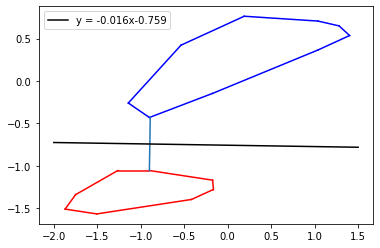

Envoltória 1

Precisão:   0.975609756097561 
Revocação:  1.0 
F1-escore:  0.9876543209876543 

Envoltória 2

Precisão:   1.0 
Revocação:  0.8 
F1-escore:  0.888888888888889


In [ ]:
#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)

  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #2

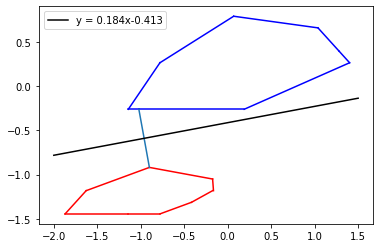

Envoltória 1

Precisão:   0.975609756097561 
Revocação:  1.0 
F1-escore:  0.9876543209876543 

Envoltória 2

Precisão:   1.0 
Revocação:  0.8 
F1-escore:  0.888888888888889


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/iris.prepared.csv'
atribute1 = 0
atribute2 = 3

#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)

  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #3

Por mais que, matemáticamente falando, a reta modelo seja perpendicular ao segmento da menor distância (a inclinação/a das duas multiplicadas dá -1), na visualização a reta parece torta. Não descobrimos a causa disso mas decidimos usar o modelo mesmo assim. Apareceram outros gráficos similares. Neste caso, podemos perceber que a menor distância entre as envoltórias não é a distância entre os vértices o que causa algumas complicações. Como este fato nao afeta tanto esse modelo (a reta não corta muito uma das envoltórias) decidimos mantê-lo para exemplificar este caso especial

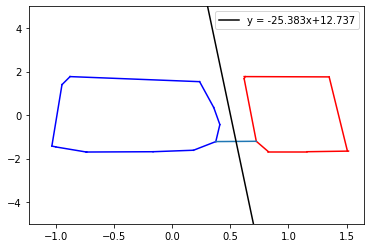

Envoltória 1

Precisão:   0.49029126213592233 
Revocação:  1.0 
F1-escore:  0.6579804560260586 

Envoltória 2

Precisão:   1.0 
Revocação:  0.8226351351351351 
F1-escore:  0.9026876737720111


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv'
atribute1 = 1
atribute2 = 0

#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-1.1,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x+' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)
    plt.ylim([-5,5])

  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #4

Outro caso onde a representação visual da reta é torta se encontra aqui. Ainda achamos importante mostrar essa peculiaridade.

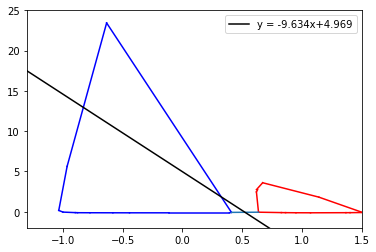

Envoltória 1

Precisão:   0.4786729857819905 
Revocação:  1.0 
F1-escore:  0.6474358974358975 

Envoltória 2

Precisão:   1.0 
Revocação:  0.8141891891891891 
F1-escore:  0.8975791433891993


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv'
atribute1 = 1
atribute2 = 8


#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x+' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)
    plt.xlim([-1.3,1.5])
    plt.ylim([-2,25])

  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #5

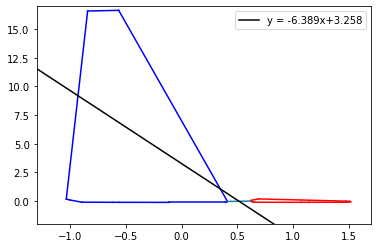

Envoltória 1

Precisão:   0.47641509433962265 
Revocação:  1.0 
F1-escore:  0.6453674121405751 

Envoltória 2

Precisão:   1.0 
Revocação:  0.8125 
F1-escore:  0.896551724137931


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv'
atribute1 = 1
atribute2 = 6


#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x+' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)
    plt.xlim([-1.3,1.7])
    plt.ylim([-2,17])

  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #6

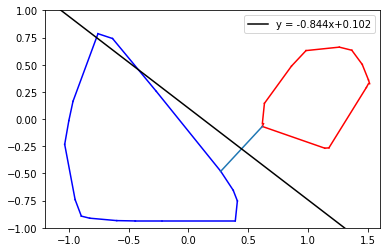

Envoltória 1

Precisão:   0.4611872146118721 
Revocação:  1.0 
F1-escore:  0.63125 

Envoltória 2

Precisão:   1.0 
Revocação:  0.793918918918919 
F1-escore:  0.8851224105461395


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv'
atribute1 = 1
atribute2 = 10


#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x+' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)
    plt.xlim([-1.2,1.6])
    plt.ylim([-1,1])

  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #7

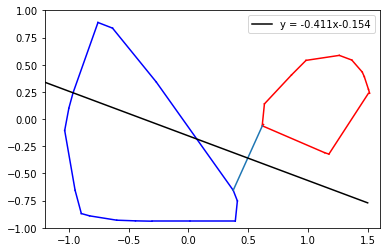

Envoltória 1

Precisão:   0.47641509433962265 
Revocação:  1.0 
F1-escore:  0.6453674121405751 

Envoltória 2

Precisão:   1.0 
Revocação:  0.8074324324324325 
F1-escore:  0.8934579439252337


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv'
atribute1 = 1
atribute2 = 12


#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)
    plt.xlim([-1.2,1.6])
    plt.ylim([-1,1])

    
  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #8

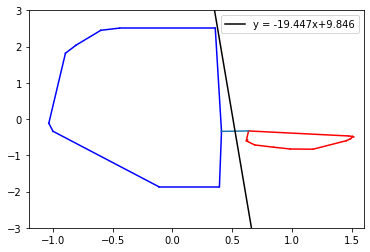

Envoltória 1

Precisão:   0.4786729857819905 
Revocação:  1.0 
F1-escore:  0.6474358974358975 

Envoltória 2

Precisão:   1.0 
Revocação:  0.8141891891891891 
F1-escore:  0.8975791433891993


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv'
atribute1 = 1
atribute2 = 17


#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x+' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)
    plt.xlim([-1.2,1.6])
    plt.ylim([-3,3])


  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #9

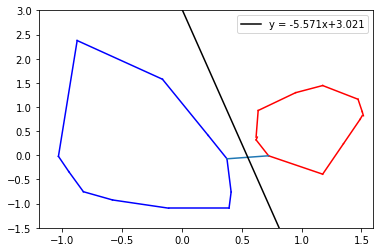

Envoltória 1

Precisão:   0.49029126213592233 
Revocação:  1.0 
F1-escore:  0.6579804560260586 

Envoltória 2

Precisão:   1.0 
Revocação:  0.8226351351351351 
F1-escore:  0.9026876737720111


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv'
atribute1 = 1
atribute2 = 14

#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x+' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)
    plt.xlim([-1.2,1.6])
    plt.ylim([-1.5,3])


  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

### Teste #10

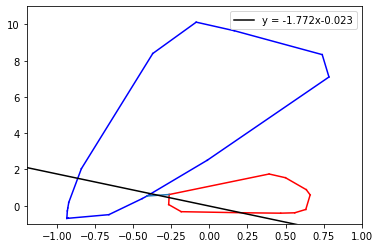

Envoltória 1

Precisão:   0.3098159509202454 
Revocação:  1.0 
F1-escore:  0.4730679156908665 

Envoltória 2

Precisão:   1.0 
Revocação:  0.6199324324324325 
F1-escore:  0.7653806047966633


In [ ]:
#Entrada para o teste
link = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv'
atribute1 = 10
atribute2 = 5


#Inicializa os pontos de cada envoltória
points0, points1 = recebeDados(link, atribute1,atribute2)

#Constrói envoltórias
envoltoria0 = graham(points0)
envoltoria1 = graham(points1)

#Segmenta envoltória para desenha-la no grafico
s1 = segmentoEnvoltoria(envoltoria0,0)
s2 = segmentoEnvoltoria(envoltoria1,1)
for i in s1:
  x1 = []
  y1 = []
  x1.append(i.endpointA.x)
  x1.append(i.endpointB.x)
  y1.append(i.endpointA.y)
  y1.append(i.endpointB.y)
  plt.plot(x1,y1,'r')

for j in s2:
  x2 = []
  y2 = []
  x2.append(j.endpointA.x)
  x2.append(j.endpointB.x)
  y2.append(j.endpointA.y)
  y2.append(j.endpointB.y)
  plt.plot(x2,y2,'b')

#Confere se é lin separavel
sep = linSeparavel(envoltoria0,envoltoria1)
a = 0
b = 0
xmid = 0

#se for traça o gráfico
if(sep):
  a,b,xmid = modelo(envoltoria0,envoltoria1)

  if(a == 0 and b == 0):
    plt.axvline(xmid)
  else:
    x = np.linspace(-2,1.5,100)
    y = a*x + b 
    equacao = 'y = ' + str("%.3f" % a) + 'x' + str("%.3f" % b)
    plt.plot(x,y,'k',label = equacao)
    plt.xlim([-1.2,1])
    plt.ylim([-1,11])


  plt.legend()

plt.show()

# verifica qual envoltoria esta acima(1) e qual esta abaixo(-1) da reta e rotula de acordo
if ( rotulaPonto(envoltoria0[0].x, envoltoria0[0].y, a, b) == 1 ):
  acima = 0
  abaixo = 1
else:
  acima = 1
  abaixo = 0

indA, indB, acimaP, acimaN, abaixoP, abaixoN = classifier(a, b, xmid, link, atribute1,atribute2, acima, abaixo)

#calcula métrica
calculaMetricas(indA, indB, acimaP, acimaN, abaixoP, abaixoN)

# Conclusão

Ao longo deste trabalho aprendemos muito sobre a implementação dos algoritmos vistos em aula e seus desafios. Alem disso também tivemos que lidar com todas as complexidades que estão envolvidas com conjunto de dados reais e como melhor adaptá-los para nossas funções. Um aspecto particularmente interessante sobre este trabalho foi perceber falhas intrinsicas ao modelo que vêm de como o modelo em si é construído. O modelo considera dois conjuntos linearmente separáveis se há interseção entre as arestas de suas envoltórias, mas há um caso onde não são separáveis mas o algoritmo, do modo como foi requisitado, não consegue detectar: se uma envoltória estiver completamente dentro de outra. Outro aspecto pra se destacar é o modelo não ser otimizado pois nem sempre a menor distância entre as envoltórias é entre os vértices como foi mencionado anteriormente neste trabalho, o que nos deixa com retas que muitas vezes cortam envoltórias e são geralmente sub-ótimas. Tendo tudo isso em mente, este trabalho foi um processo de aprendizado muito bom e esclarecedor que certamente nos ajudou a fixar os conceitos de computação geométrica. 